## Utility functions and imports

In [1]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark, mark_size=1024, N=1000):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(mark, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

In [2]:
#List of different attacks
from sklearn.metrics import roc_curve, auc

import random

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img = img.convert('L')
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

## Fourth technique

In [3]:
def calculate_parity_bits(data_bits):
    """Calculate the parity bits for a 4-bit data message."""
    p1 = data_bits[0] ^ data_bits[1] ^ data_bits[3]  # Parity for bits 1, 3, 5, 7
    p2 = data_bits[0] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 2, 3, 6, 7
    p3 = data_bits[1] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 4, 5, 6, 7
    return [p1, p2, p3]

def hamming_encode(data_bits):
    """Encode 4 data bits into a 7-bit Hamming (7,4) code."""
    if len(data_bits) != 4:
        raise ValueError("Input must be a list of 4 data bits.")
    
    # Calculate parity bits
    p1, p2, p3 = calculate_parity_bits(data_bits)
    
    # Arrange the codeword: [p1, p2, data1, p3, data2, data3, data4]
    codeword = [p1, p2, data_bits[0], p3, data_bits[1], data_bits[2], data_bits[3]]
    
    return codeword

def split_into_blocks(bit_string, block_size=4):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def encode_1024_bit_string(bit_string):
    """Encode a 1024-bit string using Hamming (7,4) encoding in blocks of 4 bits."""
    if len(bit_string) != 1024:
        raise ValueError("Input string must be exactly 1024 bits long.")
    
    # Split the bit string into 4-bit blocks
    blocks = split_into_blocks(bit_string, 4)
    
    # Prepare to store the encoded blocks
    encoded_blocks = []
    
    # Encode each 4-bit block using Hamming (7,4)
    for block in blocks:
        # Convert each 4-bit block (string) into a list of integers
        data_bits = [int(bit) for bit in block]
        
        # Encode the block and add the resulting 7-bit codeword to encoded_blocks
        encoded_blocks.append(hamming_encode(data_bits))
    
    # Flatten the list of encoded blocks into a single list of bits
    encoded_bits = [bit for block in encoded_blocks for bit in block]
    
    # Convert the list of bits into a string
    encoded_string = ''.join(map(str, encoded_bits))
    
    return encoded_string

# Example usage:
bit_string = '110101011010' * 85 + '0' * 4  # Example 1024-bit string (repeated pattern)
encoded_result = encode_1024_bit_string(bit_string)

print(len(encoded_result))
encoded_list = list(encoded_result)
print(len(encoded_list))

for _ in range(512):
    encoded_list[np.random.randint(0, 1023)] = np.random.randint(0, 1)

encoded_result = "".join([str(x) for x in encoded_list])
print(type(encoded_result))

print(f"Original 1024-bit string: {bit_string[:60]}...")  # Print a small portion for brevity
print(f"Encoded string (7,4 Hamming blocks): {encoded_result[:105]}...")  # Print a small portion for brevity
print(f"Encoded length: {len(encoded_result)} bits")

1792
1792
<class 'str'>
Original 1024-bit string: 110101011010110101011010110101011010110101011010110101011010...
Encoded string (7,4 Hamming blocks): 000010101001010011010001000001000010011010001000100000010001010000010000000011011010001010000000001010010...
Encoded length: 1792 bits


In [4]:
def hamming_decode(codeword):
    """Decode the 7-bit Hamming code, correct single-bit errors, and extract the original 4 data bits."""
    if len(codeword) != 7:
        raise ValueError("Codeword must be 7 bits long.")
    
    # Extract the parity and data bits
    p1, p2, d1, p3, d2, d3, d4 = codeword
    
    # Recalculate the parity bits based on the received data
    c1 = p1 ^ d1 ^ d2 ^ d4  # Check parity bit 1
    c2 = p2 ^ d1 ^ d3 ^ d4  # Check parity bit 2
    c3 = p3 ^ d2 ^ d3 ^ d4  # Check parity bit 3
    
    # Combine the parity check results into a single error syndrome
    error_position = (c3 << 2) | (c2 << 1) | c1  # Binary value gives error position
    
    # If error_position is non-zero, correct the error
    if error_position != 0:
        codeword[error_position - 1] ^= 1  # Flip the bit at the error position
    
    # Extract the original data bits from the corrected codeword
    data_bits = [codeword[2], codeword[4], codeword[5], codeword[6]]
    
    return data_bits

def split_into_blocks(bit_string, block_size):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def decode_1792_bit_string(encoded_string):
    """Decode a 1792-bit Hamming (7,4) encoded string back into a 1024-bit string."""
    if len(encoded_string) != 1792:
        raise ValueError("Input string must be exactly 1792 bits long.")
    
    # Split the encoded string into 7-bit blocks
    encoded_blocks = split_into_blocks(encoded_string, 7)
    
    # Prepare to store the decoded data bits
    decoded_data_bits = []
    
    # Decode each 7-bit block and extract the original 4 data bits
    for block in encoded_blocks:
        # Convert the 7-bit block (string) into a list of integers
        codeword = [int(bit) for bit in block]
        
        # Decode the block to get the original 4 data bits
        decoded_bits = hamming_decode(codeword)
        
        # Append the decoded 4 data bits to the result
        decoded_data_bits.extend(decoded_bits)
    
    # Convert the list of decoded data bits into a string
    decoded_string = ''.join(map(str, decoded_data_bits))
    
    return decoded_string

# Example usage:
decoded_result = decode_1792_bit_string(encoded_result)

print(f"Decoded 1024-bit string: {decoded_result[:60]}...")  # Print a small portion for brevity
print(f"Decoded length: {len(decoded_result)} bits")
print(decoded_result == bit_string)

print(similarity(np.asarray(list(decoded_result), dtype=np.uint8), np.asarray(list(bit_string), dtype=np.uint8)))

Decoded 1024-bit string: 010101011010000001011010100100000010000000001010111000001010...
Decoded length: 1024 bits
False
0.9005694533841939


Extracted mark:  11111110110011001011001100111101001110100111111111111111100110011111110101010100001100011111010101011110011111110101010101010100101101111111101101010000110010110101101000011111111111000111101010100000000001011001111000000000000000000000001001100011110001001010100101111000011010011001100101101001111001100110111000001100110100101110100111111111101001000000001100111101001110100101010100001111110100111001100000000010010110011000100101110100110101010001111110100110000110110011011110000011110110011000111101100111111111100001111111110110011110100100000001011010111000001010101101001100110001010101101001110011001100111100110100110010110101101001101010101001010001111111000000110011101001110100101001011000011100001110000111011010100110001001010001111101010101111001011010101101001010101101001001100100011111010101101101010110100010110100110010101011101001001100111100001110000000111100110011101001100110010011001000011101101011010011111111000111101100110011001101101010011000110011111

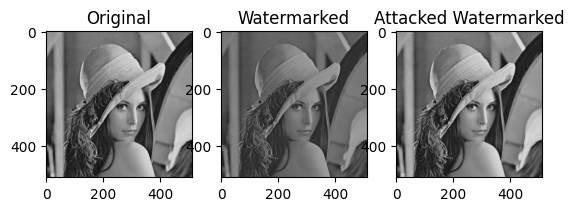

In [14]:
def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask += compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')

    mark = "".join([str(x) for x in mark])
    enc_mark = encode_1024_bit_string(mark)
    enc_mark = np.asarray(list(enc_mark), dtype=np.uint8)
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, enc_mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1792

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc]

        
    return  np.clip(extracted_mark, 0, 1).astype(np.uint8)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []

    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms

def detection(original, watermarked, attacked, alpha, max_layer):
    w_ex = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    w_ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    # w_ex_from_original = detect_wm(original, original, alpha, max_layer=max_layer)

    thr = 0.7045
    sim = []

    decoded_ex_attacked = []
    #decoded_ex_original = []

    for w in w_ex_attacked:
        w = "".join([str(x) for x in w])
        decoded_w = decode_1792_bit_string(w)
        decoded_ex_attacked.append(np.asarray(list(decoded_w), dtype=np.uint8))

    # for w in w_ex_from_original:
    #     w = "".join([str(x) for x in w])
    #     decoded_w = decode_1792_bit_string(w)
    #     decoded_ex_original.append(np.asarray(list(decoded_w), dtype=np.uint8))

    ex_mark = np.zeros(1792, dtype=np.uint8)
    for j in range(1792):
        s = 0
        for i in range(len(w_ex)):
            s += w_ex[i][j]
        if s >= 5:
            ex_mark[j] = 1
        else:
            ex_mark[j] = 0
    
    ex_mark = "".join([str(x) for x in ex_mark])
    print("Extracted mark: ", ex_mark)
    decoded_ex_wm = decode_1792_bit_string(ex_mark)
    decoded_ex_wm = np.asarray(list(decoded_ex_wm), dtype=np.uint8)

    ex_decoded_watermark = []

    for w in w_ex_attacked:
        w = "".join([str(x) for x in w])
        dw = decode_1792_bit_string(w)
        ex_decoded_watermark.append(np.asarray(list(dw), dtype=np.uint8))


    ex_attacked_mark = np.zeros(1024, dtype=np.uint8)
    for j in range(1024):
        s = 0
        for i in range(len(ex_decoded_watermark)):
            s += ex_decoded_watermark[i][j]
        
        if s>=5:
            ex_attacked_mark[j] = 1
        else:
            ex_attacked_mark[j] = 0


    for w in ex_decoded_watermark:
        x = similarity(w, decoded_ex_wm)
        sim.append(x)

    # sim_or = []
    # for w in decoded_ex_original:
    #     print("".join([str(bit) for bit in w]))
    #     x = similarity(w, decoded_ex_wm)
    #     sim_or.append(x)
        
    
    # sim_or  = max(sim_or)
    sim = max(sim)

    print("Similarity between the watermark and the one extracted from the attacked image", sim)

    print("Similarity between the watermark and the original: ", similarity(mark, decoded_ex_wm))
    
    # print(sim_or)

    if sim >= thr:
        return 1
    return 0




imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')
alpha = 0.8
img = cv2.imread('lena_grey.bmp', 0)
img2 = imgs[0]
wm = embedding(img, mark, alpha, 2)

attacked = jpeg_compression(img, QF=90)
# attacked = awgn(wm, 50, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(wm, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

is_wm = detection(img, wm, attacked, alpha, 2)

if is_wm:
    print("found")
else:
    print("not found")

print(wpsnr(wm, img))
print(wpsnr(attacked, wm))


# print(f"Not attacked - WPSNR: {wpsnr(wm, img)}, sim: {sim}")

# w_ex = detection(img, attacked, alpha)

# sim = []
# for w in w_ex:
#     sim.append(similarity(mark, w))

# sim = max(sim)

# print(f"Attacked - WPSNR: {wpsnr(attacked, wm)}, sim: {sim}")

# cv2.imwrite('./out/watermarkedPicture.bmp', wm)

# # Load the images
# image1 = cv2.imread('lena_grey.bmp')
# image2 = cv2.imread('./out/watermarkedPicture.bmp')

# # Convert images to the same data type (uint8)
# image1 = image1.astype(np.uint8)
# image2 = image2.astype(np.uint8)

# # Perform the XOR operation
# xor_image = cv2.bitwise_xor(image1, image2)

# # Save or display the result
# cv2.imwrite('./out/xor_output_image.bmp', xor_image)

wm_imgs = []
wpsnr_wm_imgs = []


# wm = embedding(imgs[4], mark, alpha)
# print(wpsnr(imgs[4], wm))
# for img in imgs:
#     wm = embedding(img, mark, alpha, max_layer=1 )
#     wm_imgs.append(wm)
#     wpsnr_wm_imgs.append(wpsnr(img, wm))

# print("mean wpsnr: ", np.mean(wpsnr_wm_imgs))  


# lost = 0
# for org_img, wm_img, quality in zip(imgs, wm_imgs, wpsnr_wm_imgs):
#     w_ex = detection(org_img, wm_img, alpha)
#     attacked_wimg = awgn(wm_img, 24, np.random.seed(123))
#     w_ex_attacked = detection(org_img, attacked_wimg, alpha, max_layer=1)

#     print("WPSNR watermarked img before being attacked: ", quality);
#     print("WPSNR watermarked img after being attackted: ", wpsnr(attacked_wimg, wm_img))

#     sim_attacked = []
#     sim_not_attacked = []
#     for w, aw in zip(w_ex, w_ex_attacked):
#         sim_not_attacked.append(similarity(mark, w))
#         sim_attacked.append(similarity(w, aw))
    
#     sim_not_attacked = max(sim_not_attacked)
#     sim_attacked = max(sim_attacked)
    
#     t, _ = compute_thr(sim_not_attacked, mark)

#     print('\n')
#     if sim_not_attacked > t:
#         print('Mark has been found in the non-attacked image. SIM = %f' % sim_not_attacked)
#     else:
#         print('Mark has been lost in the non-attacked image. SIM = %f' % sim_not_attacked)
#     if sim_attacked > t or wpsnr(attacked_wimg, wm_img) < 35:
#         print('Mark has been found in the attacked image. SIM = %f' % sim_attacked)
#     else:
#         lost += 1
#         print('Mark has been lost in the attacked image. SIM = %f' % sim_attacked)
#     print('--------------------------')
#     print('\n')


# p = (lost/len(imgs)) * 100
# print("Watermark lost in %2f of the images" % p);
# print(f"Watermark has been lost in {lost}/{len(imgs)} images")


In [ ]:
print(np.mean(wpsnr_wm_imgs))

In [ ]:
def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask += compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])

            # wm_new[loc] = wm[loc] * (1 + (modular_alpha * mark * mask))
            # wm_new = wm[loc] + wm[ * wm(alpha * mask * mark)
            # (wm_new - wm)/wm = wm(alpha * mask * mark)
            # (wm_new - wm) / (wm^2 * alpha * mask) = mark 
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            # extracted_mark[idx] = ((watermarked_subband[loc] / subband[loc]) - 1) / (modular_alpha(layer, theta, alpha) * mask[x][y])
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc]


        
    return  np.clip(extracted_mark, 0, 1).astype(np.uint8)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []

    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms

def detection(original, watermarked, attacked, alpha, max_layer):
    w_ex = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    w_ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    thr = 0.7045
    sim = []


    ex_mark = np.zeros(1024, dtype=np.uint8)
    for j in range(1024):
        s = 0
        for i in range(len(w_ex)):
            s += w_ex[i][j]
        if s >= 5:
            ex_mark[j] = 1
        else:
            ex_mark[j] = 0
        
    for w in w_ex_attacked:
        x = similarity(w, ex_mark)
        sim.append(x)
    
    sim = max(sim)

    print(sim)

    if sim >= thr:
        return 1
    return 0


In [ ]:
imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')